In [38]:
# TODO: replace df with dataframe
# TODO: investigate presence of multiple 'Plate ID' columns in condition_summary
# TODO: add dataset selector (or make new notebooks for analyzing different datasets - this might be better, think about it.)

# TODO: get rid of get_params function - just have a single list of params defined at start, then use that list. 

In [39]:
%matplotlib inline
import numpy as np
from pandas.tools.plotting import scatter_matrix
from pandas import DataFrame as df
import pandas as pd
from IPython.html.widgets import interact,fixed
import IPython.html.widgets as widgets
from view import plot_plates,\
                 matrix_tree
from toolz import pipe
from utils import normalize_columns,\
                  filter_and_drop

In [40]:
cell_path = '/notebooks/moldev-data/analyzed/07-15-2015/ssC PNA.csv'
well_path = '/notebooks/moldev-data/analyzed/07-15-2015/ssC PNA-wells.csv'
condition_path = '/notebooks/moldev-data/analyzed/07-15-2015/ssC PNA-conditions.csv'

# cell_path = '../moldev-data/analyzed/07-15-2015/APB PNA.csv'
# well_path = '../moldev-data/analyzed/07-15-2015/APB PNA-wells.csv'
# condition_path = '../moldev-data/analyzed/07-15-2015/APB PNA-conditions.csv'

colors = {'Blue & Red':'bwr','Blue':'Blues'}

In [41]:
well_data = pd.read_csv(well_path)

condition_data = pd.read_csv(condition_path)

raw_cell_data = pd.read_csv(cell_path)

In [42]:
# Widgets
# TODO: change this function - add new variable, and maybe have a look at the summary code.

ignore_cols = ['Plate ID','Plate Name','Date','Well Name', 'Condition', 'Base', 'Dose', 'Unit', 'Drug','Function','Concentration','Cell Type']
raw_params = filter(lambda x: x not in ignore_cols, raw_cell_data.columns.tolist())
summary_params = filter(lambda x: x not in ignore_cols, well_data.columns.tolist())
conditions = raw_cell_data['Condition'].unique().tolist()

parameter_widget = widgets.Select(value = 'Cell Count',
                                  options= summary_params,
                                  height=250)

parameter_widget_multiple = widgets.SelectMultiple(value = raw_params,
                                                   options= raw_params,
                                                   height=250)
condition_widget_multiple = widgets.SelectMultiple(options = conditions,value=conditions, height = 300)
function_widget = widgets.ToggleButtons(options = well_data['Function'].unique().tolist(), value = 'avg')
color_widget = widgets.ToggleButtons(options = colors,value = colors['Blue & Red'])

---
# Well Plate Results

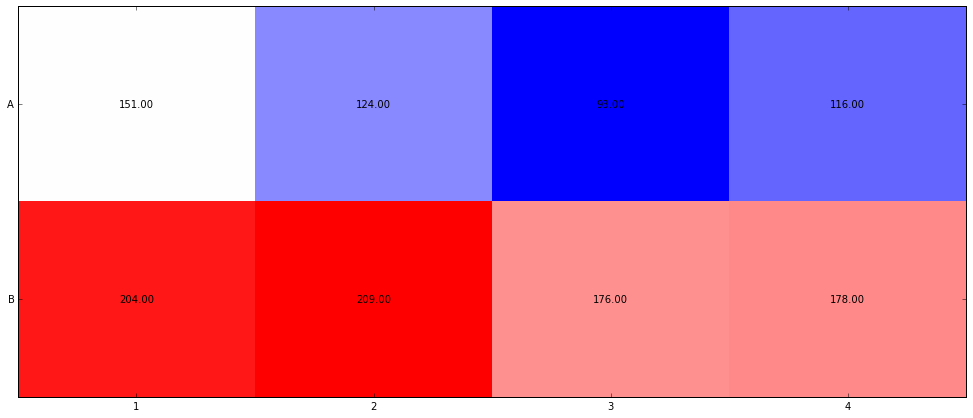

In [43]:
interact(plot_plates, 
         dataframe = fixed(well_data),
         parameter = parameter_widget,
         function = function_widget,
         color = color_widget,
         show = widgets.ToggleButtons(options=['Values','Conditions','None']));

---
# How do conditions cluster together?

In [49]:
normalized_condition_data = \
    pipe(condition_data,
    lambda x: filter_and_drop(x,'Function','avg'),
    lambda x: x.set_index('Condition'),
    lambda x: pd.DataFrame.drop(x,['Cell Type','Concentration'],axis=1),
    normalize_columns(fillna=True))
data_without_empty_params = normalized_condition_data.dropna(axis=1,how='all')

In [45]:
params_without_data = sorted(set(normalized_condition_data.columns).difference(data_without_empty_params.columns))

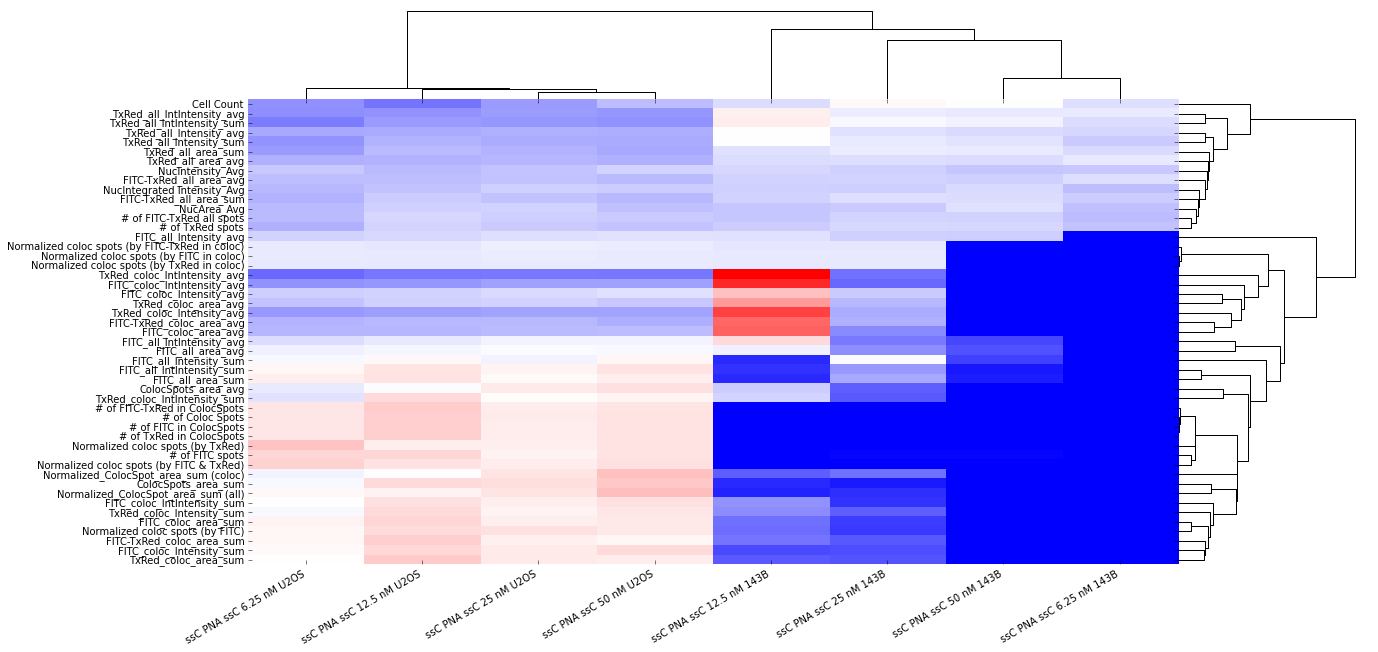

In [50]:
interact(matrix_tree, data = fixed(normalized_condition_data), color = color_widget);

---
# Heatmap subsets
The last selection box allows you to show parameters that are missing data. They shouldn't really affect clustering.

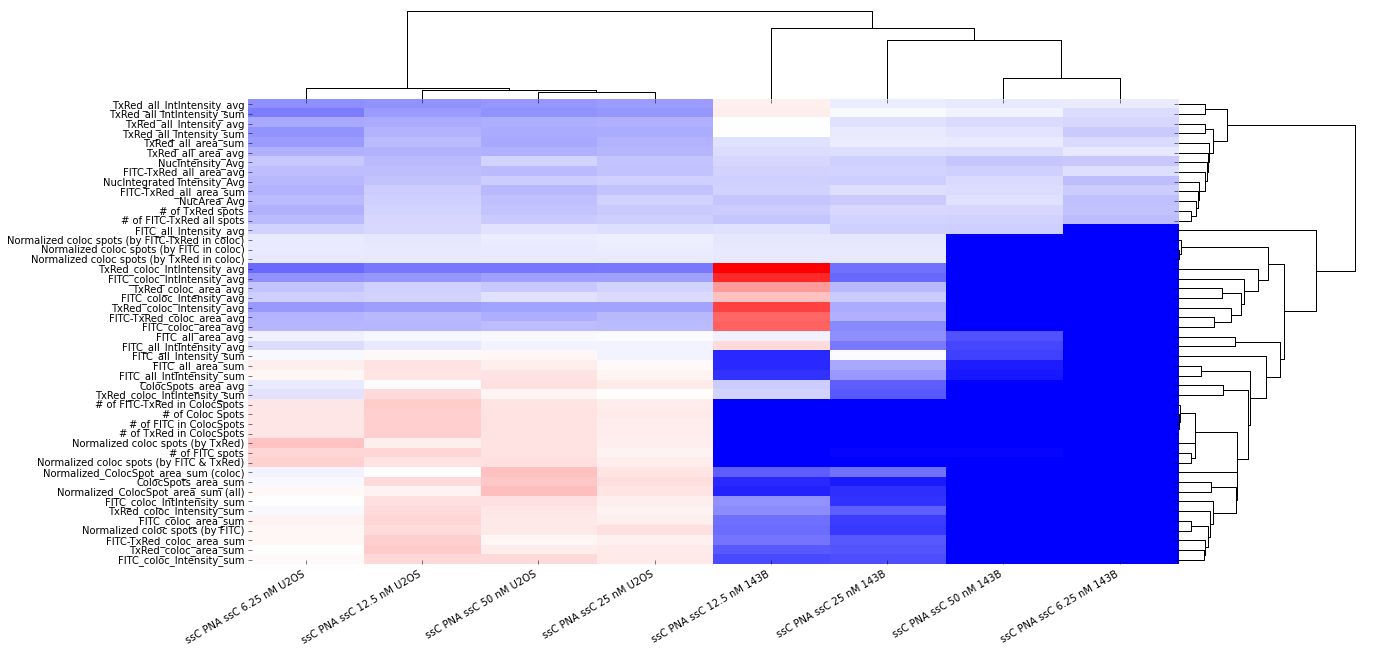

In [51]:
def wrapper(conditions,features,color):
    dataframe = normalized_condition_data.loc[list(conditions)][list(features)]
    try: 
        matrix_tree(dataframe,color)
    except:
        print "\n".join(["-"*50, "Please select multiple features and conditions.","-"*50])

interact(wrapper,
         conditions = condition_widget_multiple,
         features = parameter_widget_multiple,
         color = color_widget);

---
# Parameter vs. Conditions

In [ ]:
def plot_dist(data,parameters):        
    fig = plt.figure(num=None, figsize=(15, 7), dpi=100, facecolor='w', edgecolor='k')
    
    reshaped_data = pd.concat([add_col(data[['Condition',parameter]].rename(columns={parameter: 'Value'}),'Parameter',parameter) for parameter in parameters])
    
    sns.boxplot(x = 'Condition',
                y = 'Value',
                hue = 'Parameter',
                data = reshaped_data,
                order = sorted(data.Condition.unique()))    
    
#     plt.ylabel(parameter,fontsize=20)
    plt.xlabel('Condition',fontsize=20)
    plt.title('Distribution: ' + parameter,fontsize=20)
    plt.tick_params(labelsize=10)
    plt.xticks(rotation=30,ha='right')
    mean = data[parameter].mean()
    plt.gca().set_ylim(bottom=data[parameter].mean() * -0.5)

In [ ]:
def dist_wrapper(parameters,conditions):
    conditions = list(conditions)
    if list(parameters) == ['Cell Count']:
        dataframe = thread_first(well_data,
                                 (filter_rows,'Function','avg'),
                                 (filter_rows,'Condition',conditions))
        plot_dist(dataframe,parameters)
    else: 
        if 'Cell Count' in parameters:
            print "Ignoring cell count. Select it by itself if you want to see it."
        dataframe = filter_rows(raw_cell_data,'Condition',conditions)
        plot_dist(dataframe,filter(lambda x: x != 'Cell Count',parameters))

In [ ]:
interact(dist_wrapper,
         parameters = widgets.SelectMultiple(options = get_params(raw_cell_data) + ['Cell Count'],height = 300),
         conditions = widgets.SelectMultiple(options = sorted(raw_cell_data.Condition.unique().tolist(),key = lambda x: x.split(' ')[-1]),height = 300))

---
# Compare conditions

In [ ]:
def compare_condition_dists(dataframe, conditions, parameters, bandwidth=0.1, shaded = True, clip_ends = False, scale='linear'):
    n_rows = int(np.ceil(len(parameters)/3.0))
    plt.figure(figsize=(20,4 * n_rows))
    subs = gridspec.GridSpec(n_rows, 3) 
    plt.subplots_adjust(hspace=0.54,wspace=0.27)

    for parameter,sub in zip(parameters,subs):
        plt.subplot(sub)
        param_bandwidth = bandwidth * dataframe[dataframe.Condition == conditions[0]][parameter].mean()
        for condition in conditions:
            data = dataframe[dataframe.Condition == condition][parameter]
            kws = {"shade": shaded, "bw": param_bandwidth}
            if clip_ends: 
                kws = assoc(kws,"cut",0)
            sns.distplot(data, hist=False, kde_kws=kws,label=condition)
            plt.legend(loc = 0,fontsize=8)
        if scale == 'linear':
            plt.xlim(left=0)
        else:
            plt.xscale('log')
        plt.ylabel('Frequency')

In [ ]:
try:    
    interact(compare_condition_dists,
             dataframe = fixed(raw_cell_data),
             conditions = widgets.SelectMultiple(options = raw_cell_data.Condition.unique().tolist(),height = 300),
             parameters = widgets.SelectMultiple(options = get_params(raw_cell_data),height = 300),
             bandwidth = (0,0.2,0.01),
             scale = widgets.ToggleButtons(options=['linear','log']));
except ValueError: 
    raise Exception("Hmm. That didn't work. Maybe one of the conditions or parameters you selected doesn't have any data.")

---
# Compare parameters

In [ ]:
def compare_parameter_dists(dataframe, conditions, parameters, bandwidth=0.1, shaded = True, clip_ends = False, scale='linear'):
    n_rows = int(np.ceil(len(conditions)/3.0))
    plt.figure(figsize=(20,4 * n_rows))
    subs = gridspec.GridSpec(n_rows, 3) 
    plt.subplots_adjust(hspace=0.54,wspace=0.27)

    for condition,sub in zip(conditions,subs):
        plt.subplot(sub)
        condition_bandwidth = bandwidth * dataframe[dataframe.Condition == condition][parameters[0]].mean()
        for parameter in parameters:
            data = dataframe[dataframe.Condition == condition][parameter]
            kws = {"shade": shaded, "bw": condition_bandwidth}
            if clip_ends: 
                kws = assoc(kws,"cut",0)
            sns.distplot(data, hist=False, kde_kws=kws,label=parameter)
            plt.legend(loc = 0,fontsize=8)
        if scale == 'linear':
            plt.xlim(left=0)
        else:
            plt.xscale('log')
        plt.ylabel('Frequency')
        plt.xlabel(condition)

In [ ]:
interact(compare_parameter_dists,
         dataframe = fixed(raw_cell_data),
         conditions = widgets.SelectMultiple(options = raw_cell_data.Condition.unique().tolist(),height = 300),
         parameters = widgets.SelectMultiple(options = get_params(raw_cell_data),height = 300),
         bandwidth = (0,0.2,0.01),
         scale = widgets.ToggleButtons(options=['linear','log']));

---
#How are different parameters related?

In [ ]:
def scatter(dataframe,cols):
    scatter_matrix(data[list(cols)], alpha=1, figsize=(20, 20), diagonal='kde');
    
interact(scatter, 
         dataframe = fixed(normalized_condition_data),
         cols = widgets.SelectMultiple(value = ['Cell Count'],
                              options= summary_params,
                              height=250));